In [89]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from pathlib import Path
import math
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

In [90]:

def find_word_Common(sample):
    """finding number of words common in both user question and archived Question"""
    uq = set(map(lambda w: w.lower().strip(), sample['qu'].split(" ")))
    aq = set(map(lambda w: w.lower().strip(), sample['qa'].split(" ")))    
    return len(uq & aq)*1.0

def find_total_word_count(sample):
    """Finding total number of words in both user and archived questions"""
    uq = set(map(lambda w: w.lower().strip(), sample['qu'].split(" ")))
    aq = set(map(lambda w: w.lower().strip(), sample['qa'].split(" ")))   
    return (len(uq) + len(aq))*1.0
#test_ml['total_word_count'] = test_ml.apply(find_total_word_count, axis=1)

def fraction_common_words(sample):
    """Finding the ratio of the number of words in common and total number of words in user and archived questions"""
    uq = set(map(lambda w: w.lower().strip(), sample['qu'].split(" ")))
    aq = set(map(lambda w: w.lower().strip(), sample['qa'].split(" "))) 
    return 1.0 * len(uq & aq)/(len(uq) + len(aq))
#test_ml['fraction_common_words'] = test_ml.apply(fraction_common_words, axis=1)

In [91]:
#calculating sigmoid score

def sigmoid(x):
    return 1 / (1 + math.exp(-x))


# Machine Learning Method3: Probabilistic classifier+Word2vec for distance feature+Cosine Sim+Sigmoid

In [92]:
QApair_df = pd.read_csv('train.csv')
QApair_df = shuffle(QApair_df)
QApair_df = QApair_df.dropna() #dropping na
QApair_df[:2]

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
876,3589,129727,100851,what is the salary of indian foreign service o...,100852,what is the salary of an indian foreign servic...,32525,"While working in India, an IFS officer can dra...",1,1,1,1,2,54,57,10,11,10.0,21.0,0.476190
1176,4819,3892,172683,what would happen to british empire and its ef...,172684,what would happen if indian people had succeed...,146655,The currency in circulation probably would hav...,1,1,1,1,1,141,125,25,23,16.0,45.0,0.355556


In [93]:
all_text = QApair_df[["qu","qa"]]
all_labels = QApair_df["is_duplicate"]
print("all text size", len(all_text))
print("All label size", len(all_labels))


all text size 8000
All label size 8000


In [94]:
all_user_text = all_text["qu"].tolist() #
all_arch_text = all_text["qa"].tolist()

In [95]:
del word_vectors
path_of_downloaded_bin = Path("C:\\Users\\ASUS\\NLP\\embeddings\\GoogleNews-vectors-negative300.bin")
word_vectors = KeyedVectors.load_word2vec_format(datapath(path_of_downloaded_bin), binary=True)

In [96]:
word_vec_dim = 300 # this number should match the embedding used
oov_vec = np.random.rand(word_vec_dim) 
def vectorize_sent(word_vectors, sent):
    word_vecs = []
    for token in word_tokenize(sent):
        if token not in word_vectors: 
            word_vecs.append(oov_vec)
        else:
            word_vecs.append(word_vectors[token].astype('float64'))
    return (np.mean(word_vecs,axis=0)).reshape(1,-1)


In [97]:
#following embeddingds are used for finding diff distances between question pairs of all vectors
all_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_user_text]) #getting vector representation for user questions
all_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_arch_text]) #getting vector representation for archived questions


In [98]:
#getting distnces
cosine_dist = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(all_user_vecs,all_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
QApair_df['cosine_dist'] = cosine_dist

In [99]:
QApair_df[:2]

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,...,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words,cosine_dist
876,3589,129727,100851,what is the salary of indian foreign service o...,100852,what is the salary of an indian foreign servic...,32525,"While working in India, an IFS officer can dra...",1,1,...,1,2,54,57,10,11,10.0,21.0,0.476190,0.012714
1176,4819,3892,172683,what would happen to british empire and its ef...,172684,what would happen if indian people had succeed...,146655,The currency in circulation probably would hav...,1,1,...,1,1,141,125,25,23,16.0,45.0,0.355556,0.080617


In [100]:
#checking if all columns are present including the columns for all newly create distance features
QApair_df.columns

Index(['Unnamed: 0', 'guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans',
       'is_duplicate', 'is_correspond', 'is_useful', 'f_uq', 'f_aq', 'l_uq',
       'l_aq', 'num_words_uq', 'num_words_aq', 'n_common_words',
       'total_word_count', 'fraction_common_words', 'cosine_dist'],
      dtype='object')

In [101]:
x_data = QApair_df[['cosine_dist']].copy()
y_data = QApair_df['is_duplicate'].copy()
all_cos_dist_scores = QApair_df["cosine_dist"]
all_labels = QApair_df["is_duplicate"]
train_dist_scores = np.array([sigmoid(x) for x in all_cos_dist_scores]).reshape(-1,1)
train_labels = all_labels

# Logistic regression+Word2vec for distance feature+Cosine distance+Sigmoid

In [102]:
#model using best params from grid search
clf = LogisticRegression(C = 10,class_weight = 'dict', max_iter = 5000, solver = 'sag').fit(train_dist_scores, train_labels)

In [103]:
#finding mean reciprocal rank:
test_df_ml = pd.read_csv('test.csv') #getting the test data
test_df_ml.columns

Index(['Unnamed: 0', 'guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans',
       'is_duplicate', 'is_correspond', 'is_useful', 'f_uq', 'f_aq', 'l_uq',
       'l_aq', 'num_words_uq', 'num_words_aq', 'n_common_words',
       'total_word_count', 'fraction_common_words'],
      dtype='object')

In [104]:
test_df_ml = test_df_ml[['guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
test_df_ml = test_df_ml[:500]
l = len(test_df_ml['qa'])#Number of archived Questions
print("Number of archived Questions:",l)

Number of archived Questions: 500


In [105]:
user_questions = test_df_ml['qu'].tolist()
LR_WV_S_reciprocal_rank_list = []
most_similar_quest_id = 0
arch_questions = test_df_ml['qa'].tolist()
for uquest_id, user_quest in enumerate(user_questions):
    test_ml = test_df_ml[['guid', 'qu_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
    test_ml.loc[:,'qu'] = [user_quest]*l #appending user question to all archived questions dataframe
    #finding distances
    ml_test_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qu'].tolist()])
    ml_test_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qa'].tolist()])
    test_ml['cosine_dist'] = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
    test_x_data = test_ml[['cosine_dist']].copy()
    test_x_data = test_x_data.values #list of cosine similarities
    test_x_data_dist = np.array([sigmoid(x) for x in test_x_data]).reshape(-1,1)
    y_pred = clf.predict_proba(test_x_data_dist) #predict probability
    #print(max(x_data))
    y_max = y_pred[:,1] #selecting only probability of duplication
    #print(max(y_max))
    most_similar_quest_id = np.argmax(np.array(y_max))
    #print(most_similar_quest_id)
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        LR_WV_S_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        LR_WV_S_reciprocal_rank_list.append(0)
       


In [106]:
LR_WV_S_mean_reciprocal_rank = np.mean(np.array(LR_WV_S_reciprocal_rank_list))
print("Mean Reciprocal Rank for Logistic regression+Basic features+Word2vec ",LR_WV_S_mean_reciprocal_rank)
print("Number of question correctly retreived for Logistic regression+Basic features+Word2Vec ", sum(LR_WV_S_reciprocal_rank_list) )

Mean Reciprocal Rank for Logistic regression+Basic features+Word2vec  0.594
Number of question correctly retreived for Logistic regression+Basic features+Word2Vec  297


# Naive bayes+Word2Vec for distance Feature+Cosine Distance+Sigmoid

In [132]:
#fitting with best params
nb = MultinomialNB(alpha = 0.1).fit(train_dist_scores,train_labels)

In [133]:
user_questions = test_df_ml['qu'].tolist()
NB_WV_S_reciprocal_rank_list = []
most_similar_quest_id = 0
arch_questions = test_df_ml['qa'].tolist()
for uquest_id, user_quest in enumerate(user_questions):
    test_ml = test_df_ml[['guid', 'qu_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
    test_ml.loc[:,'qu'] = [user_quest]*l #appending user question to all archived questions dataframe
    #finding distances
    ml_test_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qu'].tolist()])
    ml_test_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qa'].tolist()])
    test_ml['cosine_dist'] = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
    test_x_data = test_ml[['cosine_dist']].copy()
    test_x_data = test_x_data.values #list of cosine similarities
    test_x_data_dist = np.array([sigmoid(x) for x in test_x_data]).reshape(-1,1)
    y_pred = nb.predict_proba(test_x_data_dist) #predict probability
    #print(max(x_data))
    y_max = y_pred[:,1] #selecting only probability of duplication
    #print(max(y_max))
    most_similar_quest_id = np.argmax(np.array(y_max))
    #print(most_similar_quest_id)
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        NB_WV_S_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        NB_WV_S_reciprocal_rank_list.append(0)
       


In [134]:
NB_WV_S_mean_reciprocal_rank = np.mean(np.array(NB_WV_S_reciprocal_rank_list))
print("Mean Reciprocal Rank for Naivebase+Basic features_Word2Vec ",NB_WV_S_mean_reciprocal_rank)
print("Number of question correctly retreived for Naivebase+Basic features_Word2Vec: ", sum(NB_WV_S_reciprocal_rank_list))

Mean Reciprocal Rank for Naivebase+Basic features_Word2Vec  0.002
Number of question correctly retreived for Naivebase+Basic features_Word2Vec:  1


# Machine Learning Method3: Logistic regression+Glove for distance feature+Cosine Distance+Sigmoid

In [110]:
QApair_df = pd.read_csv('train.csv')
QApair_df = shuffle(QApair_df)
QApair_df = QApair_df.dropna() #dropping na
QApair_df[:2]

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
7439,6964,66901,230109,what is the meaning of an actor tattoo,230108,what does a mountain tattoo mean,195979,Tattoos mean whatever the wearer chooses. A mo...,0,1,0,1,1,40,34,9,7,3.0,16.0,0.187500
6208,4468,136865,112774,what are the best ways to deal with and or avo...,151350,what exactly is jet lag,214963,"I have written an article about Jet Lag, and I...",0,1,0,2,1,58,25,13,6,4.0,19.0,0.210526


In [111]:
all_text = QApair_df[["qu","qa"]]
all_labels = QApair_df["is_duplicate"]
print("all text size", len(all_text))
print("All label size", len(all_labels))
all_user_text = all_text["qu"].tolist() # user question to list
all_arch_text = all_text["qa"].tolist() #archived question to list

all text size 8000
All label size 8000


In [112]:
del word_vectors #deleting already loaded wordvector

In [113]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# here I load the 300-dimension vectors; loading longer embeddings would require longer time and more RAM
path_of_downloaded_files = "C:\\Users\\ASUS\\NLP\\embeddings\\glove.6B\\glove.6B.300d.txt" 

glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [114]:
word_vec_dim = 300 # this number should match the embedding used
oov_vec = np.random.rand(word_vec_dim) 
def vectorize_sent(word_vectors, sent):
    word_vecs = []
    for token in word_tokenize(sent):
        if token not in word_vectors: 
            word_vecs.append(oov_vec)
        else:
            word_vecs.append(word_vectors[token].astype('float64'))
    return (np.mean(word_vecs,axis=0)).reshape(1,-1)

vv = vectorize_sent(word_vectors, 'hello world ! this is a test sentence !')

In [115]:
#following embeddingds are used for finding diff distances between question pairs of all vectors
all_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_user_text]) #getting vector representation for user questions
all_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_arch_text]) #getting vector representation for archived questions


In [116]:
#getting distnces
cosine_dist = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(all_user_vecs,all_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
QApair_df['cosine_dist'] = cosine_dist

In [117]:
QApair_df[:2]

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,...,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words,cosine_dist
7439,6964,66901,230109,what is the meaning of an actor tattoo,230108,what does a mountain tattoo mean,195979,Tattoos mean whatever the wearer chooses. A mo...,0,1,...,1,1,40,34,9,7,3.0,16.0,0.187500,0.163312
6208,4468,136865,112774,what are the best ways to deal with and or avo...,151350,what exactly is jet lag,214963,"I have written an article about Jet Lag, and I...",0,1,...,2,1,58,25,13,6,4.0,19.0,0.210526,0.210024


In [118]:
#checking if all columns are present including the columns for all newly create distance features
QApair_df.columns

Index(['Unnamed: 0', 'guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans',
       'is_duplicate', 'is_correspond', 'is_useful', 'f_uq', 'f_aq', 'l_uq',
       'l_aq', 'num_words_uq', 'num_words_aq', 'n_common_words',
       'total_word_count', 'fraction_common_words', 'cosine_dist'],
      dtype='object')

In [119]:
x_data = QApair_df[['cosine_dist']].copy()
y_data = QApair_df['is_duplicate'].copy()
all_cos_dist_scores = QApair_df["cosine_dist"]
all_labels = QApair_df["is_duplicate"]
train_dist_scores = np.array([sigmoid(x) for x in all_cos_dist_scores]).reshape(-1,1)
train_labels = all_labels

# Logistic regression+Glove for distance feature+Cosine distance+Sigmoid

In [120]:
#model using best params from grid search
clf = LogisticRegression(C = 10,class_weight = 'dict', max_iter = 5000, solver = 'sag').fit(train_dist_scores, train_labels)

In [121]:
#finding mean reciprocal rank:
test_df_ml = pd.read_csv('test.csv') #getting the test data
test_df_ml.columns

Index(['Unnamed: 0', 'guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans',
       'is_duplicate', 'is_correspond', 'is_useful', 'f_uq', 'f_aq', 'l_uq',
       'l_aq', 'num_words_uq', 'num_words_aq', 'n_common_words',
       'total_word_count', 'fraction_common_words'],
      dtype='object')

In [122]:
test_df_ml = test_df_ml[['guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
test_df_ml = test_df_ml[:500]
l = len(test_df_ml['qa'])#Number of archived Questions
print("Number of archived Questions:",l)

Number of archived Questions: 500


In [123]:
user_questions = test_df_ml['qu'].tolist()
LR_G_S_reciprocal_rank_list = []
most_similar_quest_id = 0
arch_questions = test_df_ml['qa'].tolist()
for uquest_id, user_quest in enumerate(user_questions):
    test_ml = test_df_ml[['guid', 'qu_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
    test_ml.loc[:,'qu'] = [user_quest]*l #appending user question to all archived questions dataframe
    #finding distances
    ml_test_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qu'].tolist()])
    ml_test_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qa'].tolist()])
    test_ml['cosine_dist'] = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
    test_x_data = test_ml[['cosine_dist']].copy()
    test_x_data = test_x_data.values #list of cosine similarities
    test_x_data_dist = np.array([sigmoid(x) for x in test_x_data]).reshape(-1,1)
    y_pred = clf.predict_proba(test_x_data_dist) #predict probability
    #print(max(x_data))
    y_max = y_pred[:,1] #selecting only probability of duplication
    #print(max(y_max))
    most_similar_quest_id = np.argmax(np.array(y_max))
    #print(most_similar_quest_id)
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        LR_G_S_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        LR_G_S_reciprocal_rank_list.append(0)
       


In [130]:
LR_G_S_mean_reciprocal_rank = np.mean(np.array(LR_G_S_reciprocal_rank_list))
print("Mean Reciprocal Rank for Logistic regression+Basic features+Word2vec ",LR_G_S_mean_reciprocal_rank)
print("Number of question correctly retreived for Logistic regression+Basic features+Word2Vec ", sum(LR_G_S_reciprocal_rank_list) )

Mean Reciprocal Rank for Logistic regression+Basic features+Word2vec  0.792
Number of question correctly retreived for Logistic regression+Basic features+Word2Vec  396


# Naive bayes+Word2Vec for distance Feature+Cosine Distance+Sigmoid

In [125]:
#fitting with best params
nb = MultinomialNB(alpha = 0.1).fit(train_dist_scores,train_labels)

In [126]:
user_questions = test_df_ml['qu'].tolist()
NB_G_S_reciprocal_rank_list = []
most_similar_quest_id = 0
arch_questions = test_df_ml['qa'].tolist()
for uquest_id, user_quest in enumerate(user_questions):
    test_ml = test_df_ml[['guid', 'qu_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
    test_ml.loc[:,'qu'] = [user_quest]*l #appending user question to all archived questions dataframe
    #finding distances
    ml_test_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qu'].tolist()])
    ml_test_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qa'].tolist()])
    test_ml['cosine_dist'] = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
    test_x_data = test_ml[['cosine_dist']].copy()
    test_x_data = test_x_data.values #list of cosine similarities
    test_x_data_dist = np.array([sigmoid(x) for x in test_x_data]).reshape(-1,1)
    y_pred = nb.predict_proba(test_x_data_dist) #predict probability
    #print(max(x_data))
    y_max = y_pred[:,1] #selecting only probability of duplication
    #print(max(y_max))
    most_similar_quest_id = np.argmax(np.array(y_max))
    #print(most_similar_quest_id)
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        NB_G_S_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        NB_G_S_reciprocal_rank_list.append(0)
       


In [127]:
NB_G_S_mean_reciprocal_rank = np.mean(np.array(NB_G_S_reciprocal_rank_list))
print("Mean Reciprocal Rank for Naivebase+Basic features_Word2Vec ",NB_G_S_mean_reciprocal_rank)
print("Number of question correctly retreived for Naivebase+Basic features_Word2Vec: ", sum(NB_G_S_reciprocal_rank_list))

Mean Reciprocal Rank for Naivebase+Basic features_Word2Vec  0.002
Number of question correctly retreived for Naivebase+Basic features_Word2Vec:  1


In [135]:
results_df = pd.DataFrame()
results_df["Method"] = ["LR+WV+CD+S","NB+WV+CD+S","LR+Glove+CD+S","NB+Glove+CD+S"]
results_df["mean_reciprocal_ranks"] = [LR_WV_S_mean_reciprocal_rank,NB_WV_S_mean_reciprocal_rank,LR_G_S_mean_reciprocal_rank,NB_G_S_mean_reciprocal_rank]
results_df

,Method,mean_reciprocal_ranks
0,LR+WV+CD+S,0.594
1,NB+WV+CD+S,0.002
2,LR+Glove+CD+S,0.792
3,NB+Glove+CD+S,0.002


([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

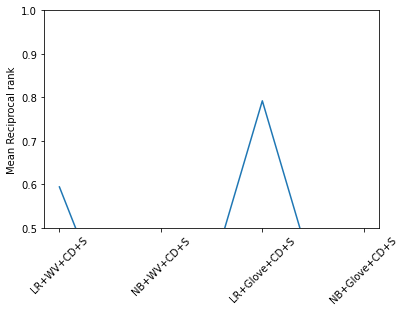

In [136]:
import matplotlib.pyplot as plt
plt.plot(results_df["Method"],results_df["mean_reciprocal_ranks"])
plt.ylabel("Mean Reciprocal rank")
plt.ylim(0.5,1)
plt.xticks(rotation = 45)